# Pangyo AI Challenge 2021 - Mask Classification Baseline

## 라이브러리 호출 및 I/O

In [1]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import json
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# # 시드(seed) 설정

# RANDOM_SEED = 2021
# torch.manual_seed(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 100
seed_everything(seed)

In [5]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

In [6]:
def image_crop(image_origin, contours):
    #margin = 
    origin_h, origin_w = image_copy.shape[:2]
    crop_images = []
    
    for contour in contours:
        x, y, width, height = cv2.boundingRect(contour)
        
        crop_row_1 = 0
        crop_row_2 = y
        crop_col_1 = 0
        crop_col_2 = height/2
        
        crop = image_copy[crop_row_1: crop_row_2, crop_col_1: crop_col_2]
        crop_images.append(crop)
        
    return crop_images
        

## Argument Setting

In [7]:
# working directory 지정
ROOT_PATH = './'
DATA_DIR = os.path.join(ROOT_PATH, 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'results')
WEIGHT_DIR = os.path.join(ROOT_PATH, 'weights')
NUMPY_DIR = os.path.join(ROOT_PATH, 'numpy')
CSV_DIR = os.path.join(ROOT_PATH, 'csv')

if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EARLY_STOPPING_PATIENCE = 5
INPUT_SHAPE = (240,120)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):

        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        if os.path.isfile(os.path.join(RESULT_DIR, 'total.pkl')):
            self.db = pd.read_pickle(os.path.join(RESULT_DIR, 'total.pkl'))
        else:
            self.db = self.data_loader()
            self.db = self.db.sample(frac=1).reset_index()
            self.db.to_pickle(os.path.join(RESULT_DIR, 'total.pkl'))
            
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
            
        mask_image_list = os.listdir(os.path.join(self.data_dir, 'Mask'))
        nomask_image_list = os.listdir(os.path.join(self.data_dir, 'NoMask'))
        
        
        
        
        mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
        nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
        mask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'Mask', x), mask_image_list))
        nomask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'NoMask', x), nomask_image_list))

        # encoding label (Mask : 1, No Mask : 0)
        mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
        nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
        db = mask_df.append(nomask_df, ignore_index=True)
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])
        
        #origin_height, origin_width = image_copy.shape[:2]  # get image size
        crop_images = [] 


#         for cv_img in cvimg:
#             x,y,width, height = cv2.boundingRect(cv_img)
            
#             crop_row1 = 0
#             crop_row2 = width
#             crop_col1 = 0
#             crop_col2 = height//2
            
#             crop = cv_img[crop_row1: crop_row2, crop_col1: crop_col2]
#             crop_images.append(crop)       
#             print(crop.shape)
        
        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']



## Model

In [9]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-m8xhuj2r
  Running command git clone -q https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-m8xhuj2r


In [10]:
import timm

In [11]:
# timm.list_models(pretrained=True)

In [12]:
BACKBONE = 'tf_efficientnet_b7_ns'

In [13]:
from torch.nn import functional as F
from efficientnet_pytorch import EfficientNet

class MaskClassifier(nn.Module):
    def __init__(self):
        super(MaskClassifier, self).__init__()
        self.model = timm.create_model(BACKBONE, pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

## Trainer

In [14]:
class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer, scheduler, logger):
        """ 초기화
        """
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            pred = F.softmax(pred)

            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## Metrics

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

## 학습을 위한 객체 선언

In [16]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 24388 Val set samples: 2710


In [17]:
model = MaskClassifier().to(device)

In [18]:
# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=0.0001, last_epoch=-1)
criterion = nn.CrossEntropyLoss()
metric_fn = get_metric_fn

# Set system logger
system_logger = get_logger(name='train',file_path='train_log.log')

# Set trainer
trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)

# Set earlystopper
# early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE, verbose=True, logger=system_logger)

In [19]:
train_loss_history = []
train_acc_history = []

valid_loss_history = []
valid_acc_history = []

best_val_loss = None
best_val_acc = None

for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    train_loss_history.append(trainer.train_mean_loss)
    train_acc_history.append(trainer.train_score)
    
    valid_loss_history.append(trainer.val_mean_loss)
    valid_acc_history.append(trainer.validation_score)

    # don't use early stopper
    
    if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
        best_val_loss = trainer.val_mean_loss
        criterion = trainer.val_mean_loss
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, os.path.join(WEIGHT_DIR, 
                                             f'{BACKBONE}_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}_best.pt'))
        
best_val_acc = max(valid_acc_history)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.26338043162694535, Acc: 0.8862965392816139, ROC: 0.9569441535144623
Epoch 0, Val loss: 0.1322149951451805, Acc: 0.9520295202952029, ROC: 0.9898106546854942


  5%|▌         | 1/20 [06:37<2:05:54, 397.58s/it]

Epoch 1, Train loss: 0.06298120814959794, Acc: 0.9783090044284074, ROC: 0.9971741215754933
Epoch 1, Val loss: 0.13027318618528974, Acc: 0.9575645756457565, ROC: 0.9913272446869206


 10%|█         | 2/20 [13:11<1:58:35, 395.29s/it]

Epoch 2, Train loss: 0.02944311012869407, Acc: 0.9900770870920125, ROC: 0.9992974171373975


 15%|█▌        | 3/20 [19:49<1:52:22, 396.65s/it]

Epoch 2, Val loss: 0.1349657313337139, Acc: 0.9656826568265683, ROC: 0.9917908019540721
Epoch 3, Train loss: 0.017505476350485695, Acc: 0.9942594718714122, ROC: 0.9997572139938015


 20%|██        | 4/20 [26:23<1:45:32, 395.75s/it]

Epoch 3, Val loss: 0.1518983471852427, Acc: 0.9649446494464945, ROC: 0.9920905541292254
Epoch 4, Train loss: 0.014763493491234025, Acc: 0.9952435624077415, ROC: 0.999768973134643


 25%|██▌       | 5/20 [32:59<1:38:56, 395.80s/it]

Epoch 4, Val loss: 0.14756129670525853, Acc: 0.9682656826568266, ROC: 0.99184094636999
Epoch 5, Train loss: 0.016648952650093824, Acc: 0.9955305888141709, ROC: 0.9997704318460874


 30%|███       | 6/20 [39:34<1:32:17, 395.56s/it]

Epoch 5, Val loss: 0.14989116118703183, Acc: 0.9686346863468634, ROC: 0.990392887070318
Epoch 6, Train loss: 0.017144779410454083, Acc: 0.9953255699524356, ROC: 0.9995847695305067
Epoch 6, Val loss: 0.1261909091889607, Acc: 0.9712177121771217, ROC: 0.9934840117315648


 35%|███▌      | 7/20 [46:12<1:25:49, 396.11s/it]

Epoch 7, Train loss: 0.006440783721436948, Acc: 0.9981548302443825, ROC: 0.9999664840403516


 40%|████      | 8/20 [52:47<1:19:10, 395.89s/it]

Epoch 7, Val loss: 0.14232190429714583, Acc: 0.9686346863468634, ROC: 0.9932917914705462
Epoch 8, Train loss: 0.009372477421597226, Acc: 0.9972937510250943, ROC: 0.9999157800562315


 45%|████▌     | 9/20 [59:25<1:12:41, 396.53s/it]

Epoch 8, Val loss: 0.13324611300958, Acc: 0.9642066420664207, ROC: 0.9931491584652689
Epoch 9, Train loss: 0.008950982620369623, Acc: 0.997047728391012, ROC: 0.999919474999843


 50%|█████     | 10/20 [1:06:00<1:06:00, 396.09s/it]

Epoch 9, Val loss: 0.1784557170785532, Acc: 0.9682656826568266, ROC: 0.9930432980316647
Epoch 10, Train loss: 0.008445547546954472, Acc: 0.9973347547974414, ROC: 0.9999211538941468


 55%|█████▌    | 11/20 [1:12:34<59:19, 395.47s/it]  

Epoch 10, Val loss: 0.18757728273759802, Acc: 0.9686346863468634, ROC: 0.9911695683568679
Epoch 11, Train loss: 0.005709959508893131, Acc: 0.9981548302443825, ROC: 0.9999551583845149


 60%|██████    | 12/20 [1:18:25<50:55, 381.97s/it]

Epoch 11, Val loss: 0.14103322454356115, Acc: 0.9715867158671587, ROC: 0.993685146555413
Epoch 12, Train loss: 0.006777236791482859, Acc: 0.9979088076103001, ROC: 0.9999387719632661


 65%|██████▌   | 13/20 [1:24:56<44:52, 384.59s/it]

Epoch 12, Val loss: 0.15463035858169727, Acc: 0.9715867158671587, ROC: 0.9940707013978034
Epoch 13, Train loss: 0.006735242422987743, Acc: 0.9981548302443825, ROC: 0.9999226814127349


 70%|███████   | 14/20 [1:31:34<38:52, 388.69s/it]

Epoch 13, Val loss: 0.1679152563182572, Acc: 0.9690036900369003, ROC: 0.9934076807873341
Epoch 14, Train loss: 0.0038240005607736243, Acc: 0.9986468755125472, ROC: 0.9999867890284284


 75%|███████▌  | 15/20 [1:38:07<32:30, 390.11s/it]

Epoch 14, Val loss: 0.18420645784547723, Acc: 0.970110701107011, ROC: 0.9934216097917559
Epoch 15, Train loss: 0.007734831633683974, Acc: 0.9977037887485649, ROC: 0.9998864544516284


 80%|████████  | 16/20 [1:44:44<26:08, 392.18s/it]

Epoch 15, Val loss: 0.1512341381564441, Acc: 0.9675276752767528, ROC: 0.9932511187776352
Epoch 16, Train loss: 0.0048508718506419, Acc: 0.9983188453337707, ROC: 0.9999837959176818


 85%|████████▌ | 17/20 [1:51:20<19:39, 393.29s/it]

Epoch 16, Val loss: 0.18162534176588063, Acc: 0.9704797047970479, ROC: 0.9918704758593638
Epoch 17, Train loss: 0.005820028911511875, Acc: 0.9982778415614236, ROC: 0.9998716677964686


 90%|█████████ | 18/20 [1:57:55<13:07, 393.77s/it]

Epoch 17, Val loss: 0.1590806207533103, Acc: 0.9719557195571956, ROC: 0.9928248912423335
Epoch 18, Train loss: 0.005928891408495422, Acc: 0.9986058717402001, ROC: 0.9998439385175971


 95%|█████████▌| 19/20 [2:04:33<06:35, 395.06s/it]

Epoch 18, Val loss: 0.20351317929341278, Acc: 0.9564575645756458, ROC: 0.9919819078947368
Epoch 19, Train loss: 0.0043383190630721085, Acc: 0.9987698868295883, ROC: 0.9999454841001244


100%|██████████| 20/20 [2:11:10<00:00, 393.55s/it]

Epoch 19, Val loss: 0.16525715608777694, Acc: 0.9671586715867159, ROC: 0.9919490354443018


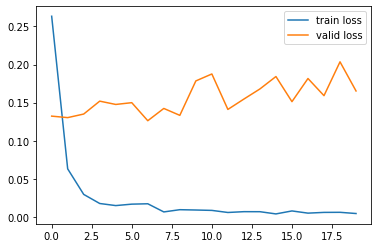

In [20]:
plt.plot(train_loss_history, label="train loss")
plt.plot(valid_loss_history, label="valid loss")
plt.legend()
plt.show()

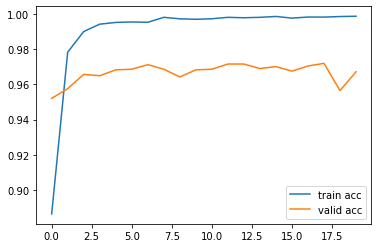

In [21]:
plt.plot(train_acc_history, label="train acc")
plt.plot(valid_acc_history, label="valid acc")
plt.legend()
plt.show()

In [22]:
TIME = datetime.now().strftime('%m%d%H%M%S')

save_dict = {'backbone':BACKBONE,
             'time':TIME,
             'best_val_loss':best_val_loss,
             'best_val_acc':best_val_acc,
             'test_score':None,
             'epochs':EPOCHS,
             'input_shape':INPUT_SHAPE,
             'augmentation':'ImageCrop(cv2)(180,180)',
             'optimizer':'Adam',
             'scheduler':'CosineAnnealingWarmRestarts',
             'attention_module':None,
             'learning_rate':LEARNING_RATE,
             'batch_size':BATCH_SIZE,
             'loss':'CrossEntropyLoss',
             'freeze':None,
             'others':'LabelSmoothing',
             'randomeseed':seed,
             'train_loss':train_loss_history,
             'train_acc':train_acc_history,
             'valid_loss':valid_loss_history,
             'valid_acc':valid_acc_history}


with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
    json.dump(save_dict, f)

In [23]:
# check how it looks
# load_dict

## Inference

In [24]:
TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}_best.pt')

#### Test set Loader

In [25]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        image_list = os.listdir(self.data_dir)
        image_list = [item for item in image_list if item[-4:] == '.png']
        image_path = list(map(lambda x : os.path.join(self.data_dir, x), image_list))
        db = pd.DataFrame({'img_path':image_path, 'file_num':list(map(lambda x : x.split('.')[0], image_list))})
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_num']

In [26]:
DATA_DIR=os.path.join(ROOT_PATH, 'test')

# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


In [27]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_num_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in enumerate(test_dataloader):
        img = img.to(device)
        pred = model(img)
        file_num_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

#### Save results as csv file

In [28]:
TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')

In [29]:
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

In [30]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        image_list = os.listdir(self.data_dir)
        image_list = [item for item in image_list if item[-4:] == '.png']
        image_path = list(map(lambda x : os.path.join(self.data_dir, x), image_list))
        db = pd.DataFrame({'img_path':image_path, 'file_num':list(map(lambda x : x.split('.')[0], image_list))})
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_num']

In [31]:
TEST_DIR=os.path.join(ROOT_PATH, 'test')

# Load dataset & dataloader
test_dataset = TestDataset(data_dir=TEST_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


In [32]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_num_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in enumerate(test_dataloader):
        img = img.to(device)
        pred = model(img)
        file_num_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

In [33]:
df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
df.sort_values(by=['file_name'], inplace=True)
df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}.csv'), index=False)